> Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D


#### Preprocessing

Loading CSV

In [2]:

# Load the uploaded CSV file
file_path = r"e:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,0,20.0,37.0,9.0,8.0,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,0,20.0,37.0,9.0,8.0,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,0,20.0,37.0,9.0,8.0,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,0,20.0,37.0,9.0,8.0,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,0,18.0,32.0,9.0,7.4,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84


Reformat Time Column

In [3]:
# Convert 'Periode' to datetime format
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")

# Sort by time just in case
df = df.sort_values("Periode").reset_index(drop=True)

# Show the first 3 rows to confirm
df[["Periode", "Totaal_verkochte_wegvoertuigen"]].head(3)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007-01-01,31
1,2007-02-01,39
2,2007-03-01,123


In [39]:

# Create 6 lag features for EV sales (Brownlee, Chapter 3, p. 42–44)
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)

# Drop rows with missing values due to lagging
df_lagged = df.dropna().reset_index(drop=True)

# Encode date features: extract year, month, and quarter from 'Periode'
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter

# Move 'Totaal_verkochte_wegvoertuigen' to the last column
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

display(df_lagged.head(3))

print(df_lagged.columns.tolist())


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,0,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,0,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,0,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter', 'Totaal_verkochte_wegvoertuigen']


Datasplitting

In [21]:
# Walk-forward split: start with 80% as initial train, then predict one by one
drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

initial_train_size = int(len(df_lagged) * 0.8)
walkforward_predictions = []
walkforward_actuals = []

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    
    walkforward_predictions.append(y_pred)
    walkforward_actuals.append(y_test)

print(f"Walk-forward predictions: {len(walkforward_predictions)} points")


Walk-forward predictions: 43 points


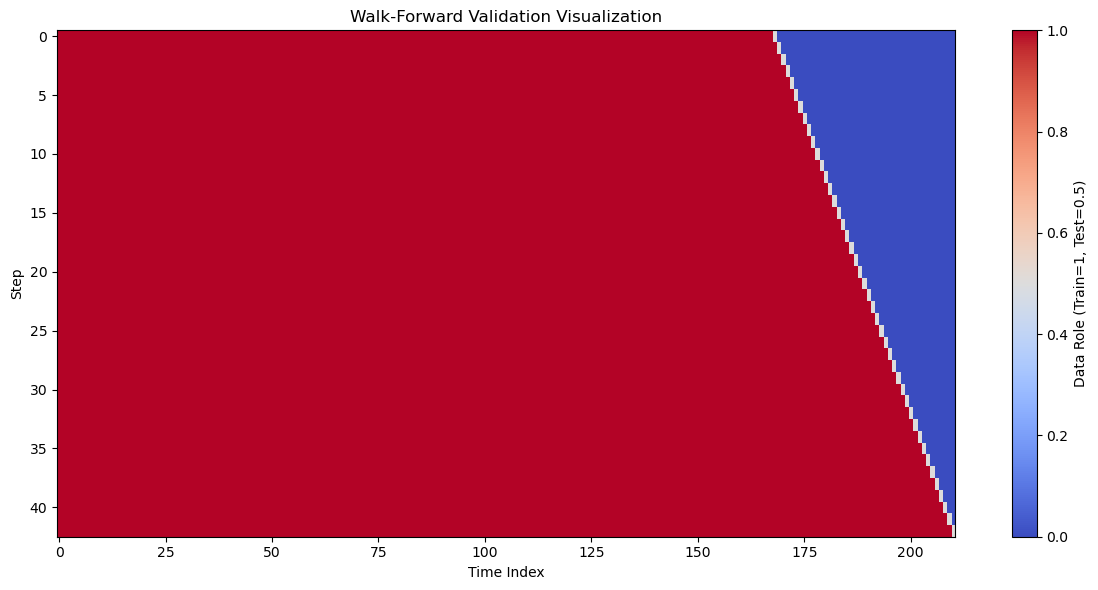

In [5]:

n_samples = len(df_lagged)
initial_train_size = int(n_samples * 0.8)
n_steps = n_samples - initial_train_size

visual_matrix = np.zeros((n_steps, n_samples))

for i in range(n_steps):
    train_end = initial_train_size + i
    visual_matrix[i, :train_end] = 1  # Train = 1
    visual_matrix[i, train_end] = 0.5  # Test point = 0.5

plt.figure(figsize=(12, 6))
plt.imshow(visual_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.title("Walk-Forward Validation Visualization")
plt.xlabel("Time Index")
plt.ylabel("Step")
plt.colorbar(label="Data Role (Train=1, Test=0.5)")
plt.tight_layout()
plt.show()


#### Corrolation 

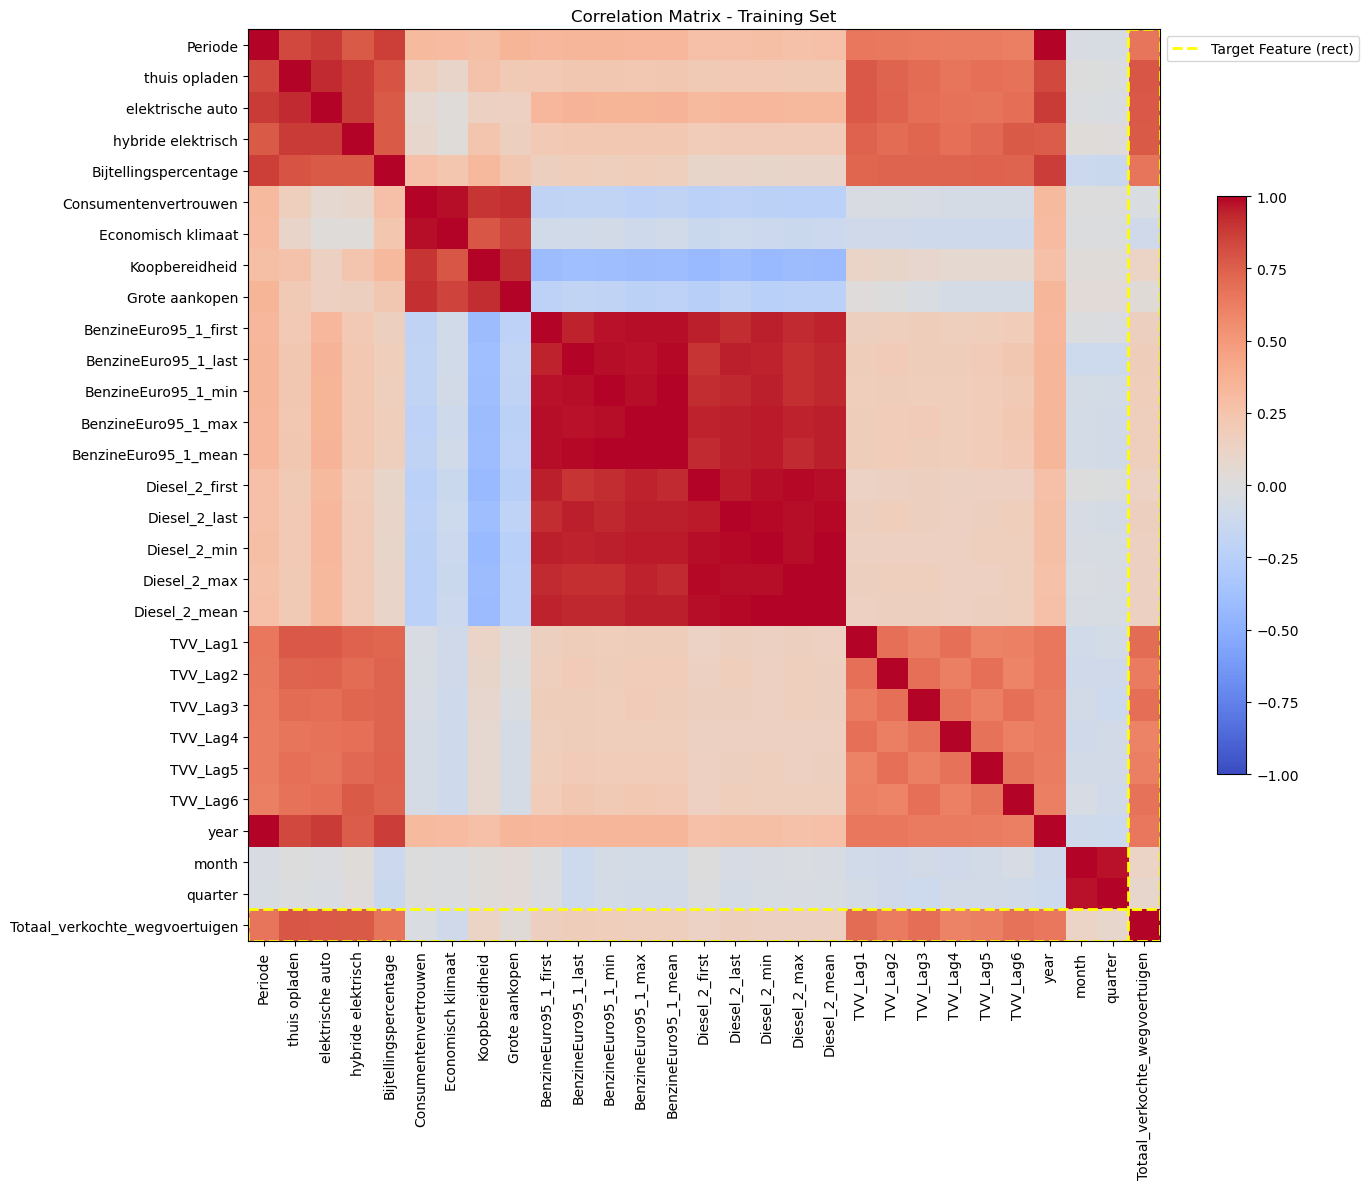

In [40]:


# Select the training set
train_df = df_lagged.iloc[:initial_train_size]

# Compute correlation matrix
corr_matrix = train_df.corr()

# Find the index of the target column
target_idx = list(corr_matrix.columns).index('Totaal_verkochte_wegvoertuigen')

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.02, pad=0.04)
plt.title("Correlation Matrix - Training Set")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Draw a rectangle around the label on both axes
plt.gca().add_patch(plt.Rectangle((target_idx - 0.5, -0.5), 1, len(corr_matrix), fill=False, edgecolor='yellow', linewidth=2, linestyle='--'))
plt.gca().add_patch(plt.Rectangle((-0.5, target_idx - 0.5), len(corr_matrix), 1, fill=False, edgecolor='yellow', linewidth=2, linestyle='--'))

# Add legend for the highlighted target
legend_elements = [
    Line2D([0], [0], color='yellow', lw=2, linestyle='--', label='Target Feature (rect)')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


### Model training op elke feature

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using XGBoost on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric="rmse")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    'Baseline (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtellingspercentage'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

# Evaluate updated configurations
results = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)

                 Model          MAE         RMSE        R²   MAPE (%)
0  Baseline (Lag Only)  2968.239014  3827.817655  0.623079  13.614085
1       Keywords + Lag  3050.220215  3969.900125  0.594578  13.155425
2     Bijtelling + Lag  2968.239014  3827.817655  0.623079  13.614085
3     Confidence + Lag  3186.555176  4345.754250  0.514177  13.588503
4           Fuel + Lag  2836.823486  3854.757450  0.617755  12.348492
5         All Features  2922.512451  3973.376901  0.593868  12.447914


Fuel + Lag presteert het best

Dit model behaalt de laagste MAE (2836.82) en MAPE (12.35%) met een R² van 0.618.

Dit suggereert dat brandstofprijzen een sterke voorspellende waarde hebben wanneer gecombineerd met historische verkoop (lag features).

Baseline (Lag Only) doet het verrassend goed

MAE van 2968.2 en R² van 0.623 tonen aan dat historische verkoopcijfers (TVV_Lag1–6) op zichzelf al sterke voorspellers zijn.

Dit maakt deze baseline een robuust referentiepunt.

All Features presteert iets slechter dan Fuel + Lag

Hoewel de foutpercentages nog steeds laag zijn, daalt de R² licht naar 0.594.

Mogelijk wordt de toegevoegde waarde van sommige features tenietgedaan door ruis (bv. zwakkere correlaties of redundantie).

Confidence + Lag presteert het minst goed

R² daalt naar 0.514 met een hogere RMSE (4345.75), wat erop wijst dat deze macro-indicatoren (zoals consumentenvertrouwen of koopbereidheid) relatief weinig verklarende kracht hebben in deze context.

Bijtelling + Lag heeft exact dezelfde resultaten als de Baseline

Dit impliceert dat de Bijtellingspercentage feature géén extra voorspellende waarde toevoegt bovenop de historische verkoop.



In [19]:
# Alleen 'All Features' gebruiken voor XGBoost walk-forward validatie
mae, rmse, r2, mape = walk_forward_validation(df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen')
print(f"All Features XGBoost:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}\nMAPE: {mape:.2f}%")


# Alleen 'Baseline (Lag Only)' gebruiken voor XGBoost walk-forward validatie
baseline_features = feature_sets['Baseline (Lag Only)']
mae_b, rmse_b, r2_b, mape_b = walk_forward_validation(df_lagged, baseline_features, 'Totaal_verkochte_wegvoertuigen')
print(f"Baseline (Lag Only) XGBoost:\nMAE: {mae_b:.2f}\nRMSE: {rmse_b:.2f}\nR²: {r2_b:.3f}\nMAPE: {mape_b:.2f}%")

All Features XGBoost:
MAE: 2922.51
RMSE: 3973.38
R²: 0.594
MAPE: 12.45%
Baseline (Lag Only) XGBoost:
MAE: 2968.24
RMSE: 3827.82
R²: 0.623
MAPE: 13.61%


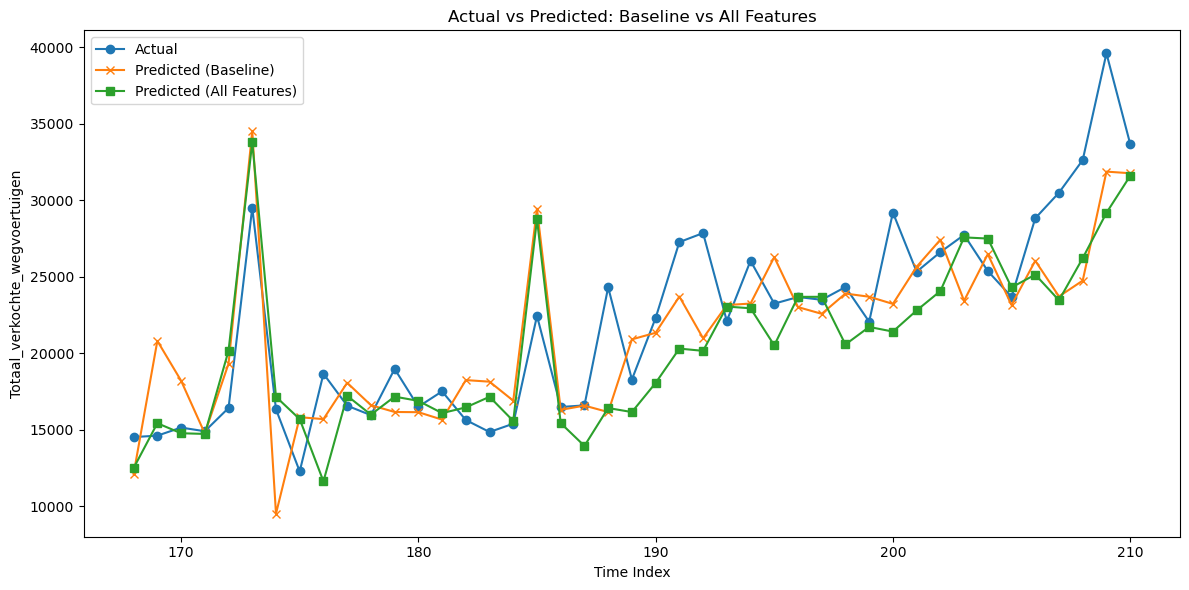

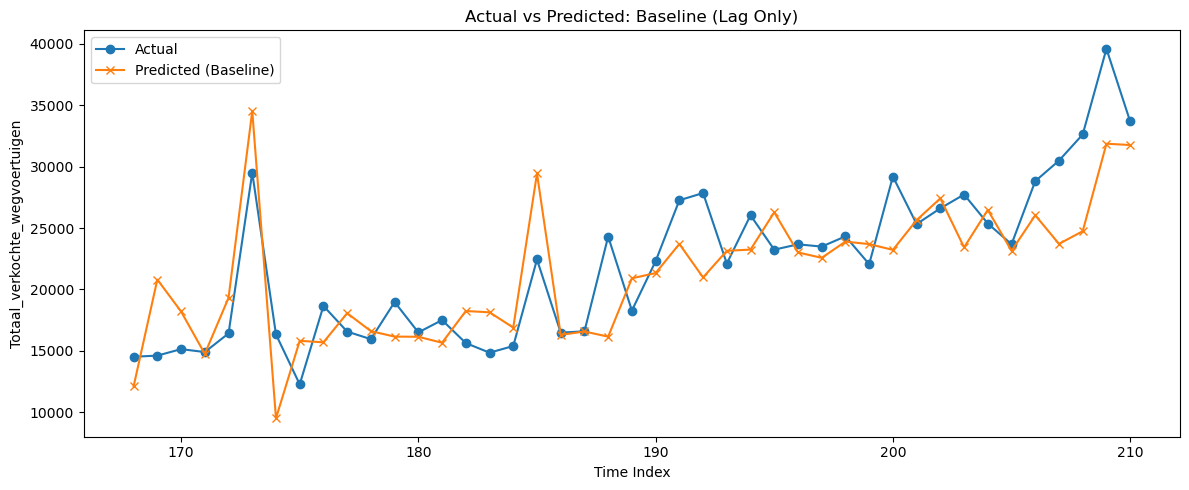

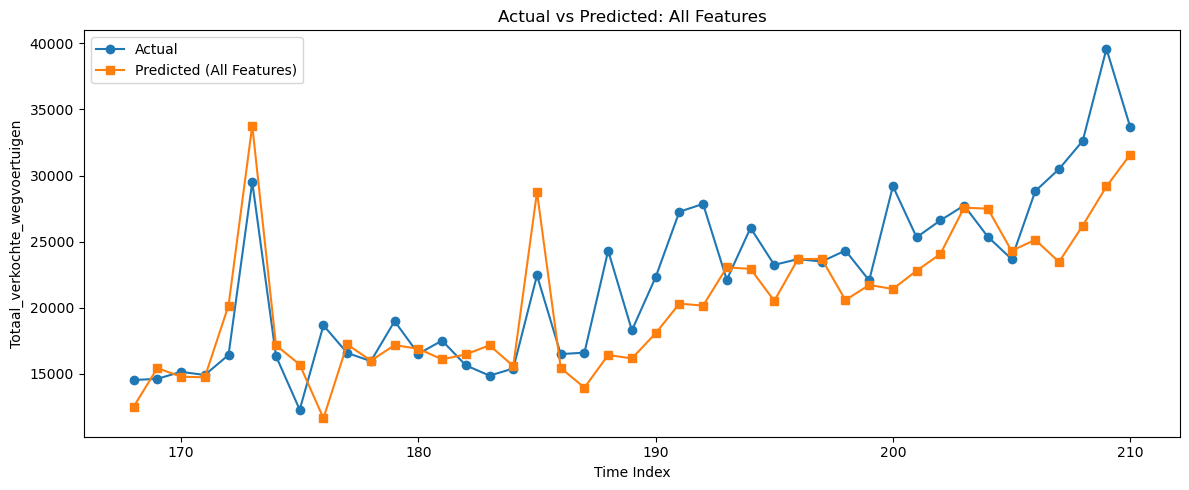

In [17]:
# Baseline (Lag Only) features
baseline_features = feature_sets['Baseline (Lag Only)']

# Walk-forward predictions for baseline
X_baseline = df_lagged[baseline_features].values
y_baseline = df_lagged['Totaal_verkochte_wegvoertuigen'].values
baseline_preds = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_baseline[:i], y_baseline[:i]
    X_test = X_baseline[i]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    baseline_preds.append(y_pred)

# 'All Features' gebruiken voor XGBoost walk-forward validatie
all_features = feature_sets['All Features']
X_all = df_lagged[all_features].values
y_all = df_lagged['Totaal_verkochte_wegvoertuigen'].values
all_preds = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_all[:i], y_all[:i]
    X_test = X_all[i]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    all_preds.append(y_pred)

# Plot actual vs predicted for both models in one figure
plt.figure(figsize=(12, 6))
idx = range(initial_train_size, len(df_lagged))
plt.plot(idx, y_baseline[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, baseline_preds, label='Predicted (Baseline)', marker='x')
plt.plot(idx, all_preds, label='Predicted (All Features)', marker='s')
plt.title('Actual vs Predicted: Baseline vs All Features')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()
# Plot beide modellen apart voor duidelijkheid

# Baseline (Lag Only)
plt.figure(figsize=(12, 5))
plt.plot(idx, y_baseline[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, baseline_preds, label='Predicted (Baseline)', marker='x')
plt.title('Actual vs Predicted: Baseline (Lag Only)')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()

# All Features
plt.figure(figsize=(12, 5))
plt.plot(idx, y_all[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, all_preds, label='Predicted (All Features)', marker='s')
plt.title('Actual vs Predicted: All Features')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()

Baseline (Lag Only):

Blauwe lijn = echt. Oranje kruisjes = baseline.

De baseline pakt de algemene trend en de seizoenspiek ruim goed, maar mist soms de exacte hoogte van de pieken/daalpunten.

All Features:

Blauwe lijn = echt. Oranje blokjes = alle features.

Dit model volgt de trend iets vlakker: grote uitschieters worden ondervoorspeld en kleine fluctuaties soms over- of ondergeschat.

Kort samengevat:

Beide modellen vangen de algemene stijgende trend in EV-verkoop.

De baseline (alleen lagged sales) doet verrassend goed voor pieken en dalen.

Het “All Features”-model is stabieler maar mist de hoogste pieken.

                  Feature  MAE Increase
25                  month    540.265625
1        elektrische auto    414.115723
20               TVV_Lag3    278.035645
19               TVV_Lag2    272.920654
5      Economisch klimaat    134.370117
24                   year    101.517090
6          Koopbereidheid     94.927490
23               TVV_Lag6     80.073242
2      hybride elektrisch     75.037598
7          Grote aankopen     63.912354
21               TVV_Lag4     61.163818
13         Diesel_2_first     52.982666
4   Consumentenvertrouwen     50.809814
14          Diesel_2_last     29.655762
16           Diesel_2_max     29.505859
17          Diesel_2_mean     20.807129
9    BenzineEuro95_1_last      9.234863
3   Bijtellingspercentage      0.028809
26                quarter      0.000000
15           Diesel_2_min     -1.658447
12   BenzineEuro95_1_mean     -8.604492
10    BenzineEuro95_1_min     -9.811768
11    BenzineEuro95_1_max    -20.105957
8   BenzineEuro95_1_first    -24.990723


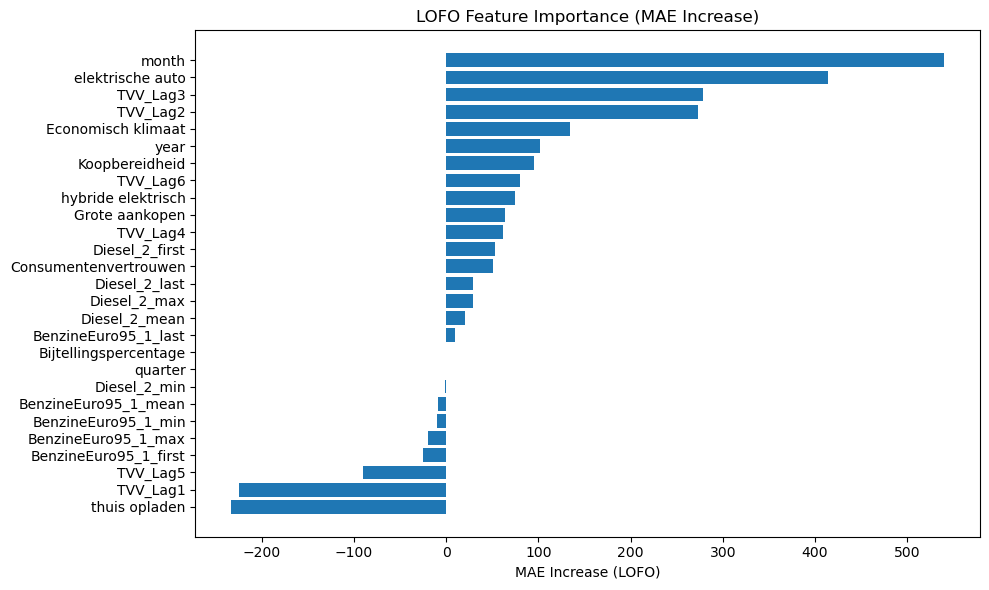

Meest belangrijke feature volgens LOFO: month


In [31]:
from sklearn.model_selection import LeaveOneOut

# LOFO = Leave-One-Out Feature Importance (not LeaveOneOut CV)
# We gebruiken hier een eenvoudige LOFO-implementatie: voor elke feature train je zonder die feature en kijk je naar de performance drop

def lofo_importance(df, features, target_col):
    baseline_mae, _, _, _ = walk_forward_validation(df, features, target_col)
    importances = []
    for feat in features:
        reduced_feats = [f for f in features if f != feat]
        mae, _, _, _ = walk_forward_validation(df, reduced_feats, target_col)
        importance = mae - baseline_mae  # hoe groter, hoe belangrijker
        importances.append({'Feature': feat, 'MAE Increase': importance})
    return pd.DataFrame(importances).sort_values('MAE Increase', ascending=False)

# Gebruik alle features behalve target en 'Periode'
lofo_df = lofo_importance(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
print(lofo_df)
# Sorteer op belangrijkheid en plot de top feature
top_feature = lofo_df.sort_values('MAE Increase', ascending=False).iloc[0]['Feature']

plt.figure(figsize=(10, 6))
plt.barh(lofo_df.sort_values('MAE Increase', ascending=True)['Feature'], 
         lofo_df.sort_values('MAE Increase', ascending=True)['MAE Increase'])
plt.xlabel('MAE Increase (LOFO)')
plt.title('LOFO Feature Importance (MAE Increase)')
plt.tight_layout()
plt.show()

print(f"Meest belangrijke feature volgens LOFO: {top_feature}")

De analyse toont dat month, elektrische auto, en historische verkoopcijfers zoals TVV_Lag2 en TVV_Lag3 de grootste bijdrage leveren aan de nauwkeurigheid van het model. Het verwijderen van deze variabelen leidt tot een duidelijke toename in MAE, wat hun voorspellende waarde onderstreept.

Aan de andere kant blijken features zoals thuis opladen, TVV_Lag1, en meerdere brandstofprijsvariabelen de prestaties juist te verslechteren. Het model presteert beter zonder deze variabelen, wat suggereert dat ze vooral ruis toevoegen.

De variabele bijtellingspercentage heeft vrijwel geen effect, en lijkt dus weinig relevant in deze context.

### 6 maanden lead target value toegevoegd 

In [29]:
# Step 1: Add 6-month lead target column
df_lagged['TVV_Lead6'] = df_lagged['Totaal_verkochte_wegvoertuigen'].shift(-6)

# Step 2: Drop last 4 rows (which now have NaN targets)
df_lagged = df_lagged.dropna(subset=['TVV_Lead6'])

# Step 3: Re-run the same model evaluations but targeting 4-months ahead
results_lead6 = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'TVV_Lead6')
    results_lead6.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

results_df_lead6 = pd.DataFrame(results_lead6)

print(results_df_lead6)




                 Model          MAE         RMSE        R²   MAPE (%)
0  Baseline (Lag Only)  3281.537657  4500.489242  0.465859  13.438426
1       Keywords + Lag  3345.821456  4596.367033  0.442858  13.702262
2     Bijtelling + Lag  3281.537657  4500.489242  0.465859  13.438426
3     Confidence + Lag  3392.980064  4589.657805  0.444483  13.913171
4           Fuel + Lag  3206.023175  4399.215932  0.489628  12.997713
5         All Features  2936.065120  4011.912652  0.575537  12.294468


Code die ik in draft 4 heb gebruikt

Alle variablen 

In [ ]:
# Use all features (feature_cols) for model training and walk-forward validation (no early stopping)

X_all = df_lagged[feature_cols].values
y_all = df_lagged[target_col].values

initial_train_size_all = int(len(df_lagged) * 0.8)
predictions_all = []
actuals_all = []

for i in range(initial_train_size_all, len(df_lagged)):
    X_train_all, y_train_all = X_all[:i], y_all[:i]
    X_test_all, y_test_all = X_all[i], y_all[i]

    model_all = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric="rmse"
    )

    model_all.fit(X_train_all, y_train_all)

    y_pred_all = model_all.predict(X_test_all.reshape(1, -1))[0]
    predictions_all.append(y_pred_all)
    actuals_all.append(y_test_all)

# Evaluation
mae_all = mean_absolute_error(actuals_all, predictions_all)
rmse_all = np.sqrt(mean_squared_error(actuals_all, predictions_all))
r2_all = r2_score(actuals_all, predictions_all)
mape_all = np.mean(np.abs((np.array(actuals_all) - np.array(predictions_all)) / np.array(actuals_all))) * 100

print("📈 Walk-Forward Validation Results (All Features, No Early Stopping)")
print(f"MAE:  {mae_all:.2f}")
print(f"RMSE: {rmse_all:.2f}")
print(f"R²:   {r2_all:.4f}")
print(f"MAPE: {mape_all:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(actuals_all, label="Actual", marker='o', color='blue')
plt.plot(predictions_all, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation, All Features)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

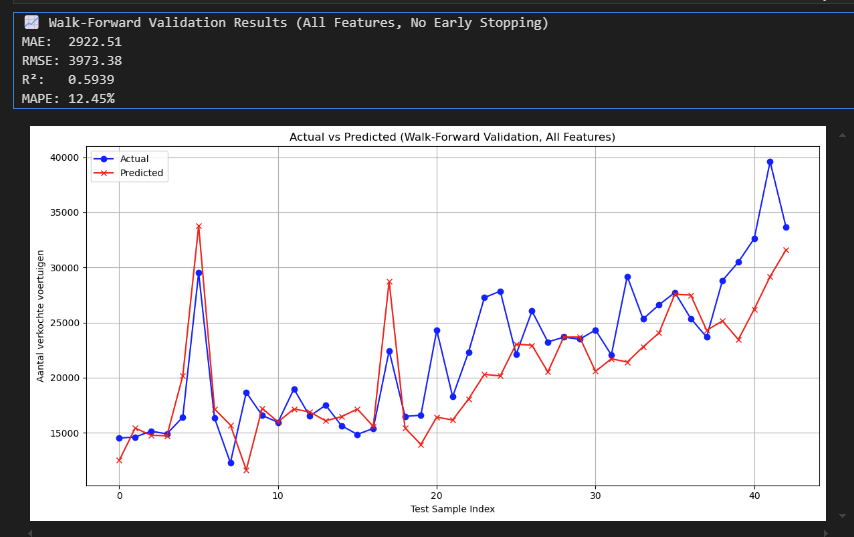